In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
import torch.nn as nn
import torch.optim as optim
from network.gap_layers import *
from datasets.datasets_pair import *
import functools
from network.sym_v1 import *
from network.flownet3d import *
from network.gpv_layers import *
from loss.utils import *
from visu.utils import *
from network.utils import *
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [7]:
root_dir = "/data/zhangran/GAPartNet_re_rendered/train"
test_intra_dir = "/data/zhangran/GAPartNet_re_rendered/test_intra"
test_inter_dir = "/data/zhangran/GAPartNet_re_rendered/test_inter"
def get_datasets(root_dir, test_intra_dir, test_inter_dir, max_points=2000, voxelization=False, shot=False, choose_category: List=None, augmentation=True):
    if shot:
        few_shot = True
        few_shot_num = 20
    else:
        few_shot = False
        few_shot_num = None

    dataset_train = GAPartNetPair(
        Path(root_dir) / "pth",
        Path(root_dir) / "meta",
        shuffle=True,
        max_points=max_points,
        augmentation=augmentation,
        voxelization=voxelization, 
        group_size=2,
        voxel_size=[0.01,0.01,0.01],
        few_shot=few_shot,
        few_shot_num=few_shot_num,
        pos_jitter=0.1,
        with_pose=True,
        color_jitter=0.3,
        flip_prob=0.3,
        rotate_prob=0.3,
        choose_category=choose_category,
    )

    dataset_test_intra = GAPartNetPair(
        Path(test_intra_dir) / "pth",
        Path(test_intra_dir) / "meta",
        shuffle=False,
        max_points=max_points,
        augmentation=augmentation,
        voxelization=voxelization, 
        group_size=2,
        voxel_size=[0.01,0.01,0.01],
        few_shot=few_shot,
        few_shot_num=few_shot_num,
        pos_jitter=0.1,
        with_pose=True,
        color_jitter=0.3,
        flip_prob=0.3,
        rotate_prob=0.3,
        choose_category=choose_category,
    )

    dataset_test_inter = GAPartNetPair(
        Path(test_inter_dir) / "pth",
        Path(test_inter_dir) / "meta",
        shuffle=False,
        max_points=max_points,
        augmentation=augmentation,
        voxelization=voxelization, 
        group_size=2,
        voxel_size=[0.01,0.01,0.01],
        few_shot=few_shot,
        few_shot_num=few_shot_num,
        pos_jitter=0.1,
        with_pose=True,
        color_jitter=0.3,
        flip_prob=0.3,
        rotate_prob=0.3,
        choose_category=choose_category,
    )

    return dataset_train, dataset_test_intra, dataset_test_inter

def get_dataloaders(dataset_train, dataset_test_intra, dataset_test_inter, batch_size=16, num_workers=8):
    dataloader_train = DataLoader(
        dataset_train,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=data_utils.trivial_batch_collator,
        pin_memory=True,
        drop_last=False
    )
    # test_intra_sampler = DistributedSampler(dataset_test_intra, shuffle=False)
    dataloader_test_intra = DataLoader(
        dataset_test_intra,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=data_utils.trivial_batch_collator,
        pin_memory=True,
        drop_last=False,
        # sampler=test_intra_sampler
    )
    # test_inter_sampler = DistributedSampler(dataset_test_inter, shuffle=False)
    dataloader_test_inter = DataLoader(
        dataset_test_inter,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=data_utils.trivial_batch_collator,
        pin_memory=True,
        drop_last=False,
        # sampler=test_inter_sampler
    )
    return dataloader_train, dataloader_test_intra, dataloader_test_inter

In [37]:
dataset_train, dataset_test_intra, dataset_test_inter = get_datasets(root_dir, test_intra_dir, test_inter_dir, voxelization=False, shot=False, choose_category=None, max_points=20000, augmentation=False)
dataloader_train, dataloader_test_intra, dataloader_test_inter = get_dataloaders(dataset_train, dataset_test_intra, dataset_test_inter, num_workers=0, batch_size=8)

In [9]:
class FaceRecon_feat(nn.Module):
    def __init__(self, gcn_n_num, gcn_sup_num):
        super(FaceRecon_feat, self).__init__()
        self.neighbor_num = gcn_n_num
        self.support_num = gcn_sup_num

        # 3D convolution for point cloud
        self.conv_0 = Conv_surface(kernel_num=128, support_num=self.support_num)
        self.conv_1 = Conv_layer(128, 128, support_num=self.support_num)
        self.pool_1 = Pool_layer(pooling_rate=4, neighbor_num=4)
        self.conv_2 = Conv_layer(128, 256, support_num=self.support_num)
        self.conv_3 = Conv_layer(256, 256, support_num=self.support_num)
        self.pool_2 = Pool_layer(pooling_rate=4, neighbor_num=4)
        self.conv_4 = Conv_layer(256, 512, support_num=self.support_num)

        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(256)

    def forward(self,
                vertices: "tensor (bs, vetice_num, 3)",
                # cat_id: "tensor (bs, 1)",
                ):
        """
        Return: (bs, vertice_num, class_num)
        """

        neighbor_index = get_neighbor_index(vertices, self.neighbor_num)
        fm_0 = F.relu(self.conv_0(neighbor_index, vertices), inplace=True)

        fm_1 = F.relu(self.bn1(self.conv_1(neighbor_index, vertices, fm_0).transpose(1, 2)).transpose(1, 2),
                      inplace=True)
        v_pool_1, fm_pool_1 = self.pool_1(vertices, fm_1)
        neighbor_index = get_neighbor_index(v_pool_1,
                                                  min(self.neighbor_num, v_pool_1.shape[1] // 8))
        fm_2 = F.relu(self.bn2(self.conv_2(neighbor_index, v_pool_1, fm_pool_1).transpose(1, 2)).transpose(1, 2),
                      inplace=True)
        fm_3 = F.relu(self.bn3(self.conv_3(neighbor_index, v_pool_1, fm_2).transpose(1, 2)).transpose(1, 2),
                      inplace=True)
        v_pool_2, fm_pool_2 = self.pool_2(v_pool_1, fm_3)
        neighbor_index = get_neighbor_index(v_pool_2, min(self.neighbor_num,
                                                                v_pool_2.shape[1] // 8))
        fm_4 = self.conv_4(neighbor_index, v_pool_2, fm_pool_2)
        nearest_pool_1 = get_nearest_index(vertices, v_pool_1)
        nearest_pool_2 = get_nearest_index(vertices, v_pool_2)
        fm_2 = indexing_neighbor(fm_2, nearest_pool_1).squeeze(2)
        fm_3 = indexing_neighbor(fm_3, nearest_pool_1).squeeze(2)
        fm_4 = indexing_neighbor(fm_4, nearest_pool_2).squeeze(2)

        feat = torch.cat([fm_0, fm_1, fm_2, fm_3, fm_4], dim=2)
        '''
        feat_face = torch.cat([fm_0, fm_1, fm_2, fm_3, fm_4], dim=2)
        feat_face = torch.mean(feat_face, dim=1, keepdim=True)  # bs x 1 x channel
        feat_face_re = feat_face.repeat(1, feat.shape[1], 1)
        '''
        return feat
    
class PoseNet9D_Only_R(nn.Module):
    def __init__(self, feat_c_R=1280, R_c=4, gcn_n_num=10, gcn_sup_num=7, face_recon_c=6 * 5, obj_c=6, feat_face=768, feat_c_ts=1289, Ts_c=6):
        super(PoseNet9D_Only_R, self).__init__()
        self.rot_green = Rot_green(feat_c_R, R_c)
        self.rot_red = Rot_red(feat_c_R, R_c)
        self.face_recon = FaceRecon_feat(gcn_n_num, gcn_sup_num)
        # self.ts = Pose_Ts(feat_c_ts, Ts_c)

    def forward(self, points):
        bs, p_num = points.shape[0], points.shape[1]
        feat = self.face_recon(points - points.mean(dim=1, keepdim=True))
        # rotation
        green_R_vec = self.rot_green(feat.permute(0, 2, 1))  # b x 4
        red_R_vec = self.rot_red(feat.permute(0, 2, 1))   # b x 4
        # normalization
        p_green_R = green_R_vec[:, 1:] / (torch.norm(green_R_vec[:, 1:], dim=1, keepdim=True) + 1e-6)
        p_red_R = red_R_vec[:, 1:] / (torch.norm(red_R_vec[:, 1:], dim=1, keepdim=True) + 1e-6)
        # sigmoid for confidence
        f_green_R = F.sigmoid(green_R_vec[:, 0])
        f_red_R = F.sigmoid(red_R_vec[:, 0])
        # translation and size no need
        return p_green_R, p_red_R, f_green_R, f_red_R

class test_GPV(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = PoseNet9D_Only_R(feat_c_R=1280)
    
    def forward(self, pc_list: List[PointCloudPair]):
        points1 = torch.cat([pc.pc1.points.unsqueeze(0) for pc in pc_list], dim=0)  # pc_list is batch size
        points2 = torch.cat([pc.pc2.points.unsqueeze(0) for pc in pc_list], dim=0)
        p_green_R1, p_red_R1, f_green_R1, f_red_R1 = self.backbone(points1[:,:, 0:3])
        p_green_R2, p_red_R2, f_green_R2, f_red_R2 = self.backbone(points2[:,:, 0:3])
        return (p_green_R1, p_red_R1, f_green_R1, f_red_R1), (p_green_R2, p_red_R2, f_green_R2, f_red_R2)

In [43]:
gpv_net = test_GPV().cuda()
gpv_net.load_state_dict(torch.load("log_dir/GPV_test_new_loss/2024-06-09 13:38:03.887472/GPV_[100|100].pth"))
gpv_net.eval()

flownet = FlowNet3D().cuda()
flownet.load_state_dict(torch.load("/home/zhangran/desktop/GithubClone/flownet3d_pytorch/pretrained_model/model.best.t7"))
flownet.eval()

FlowNet3D(
  (sa1): PointNetSetAbstraction(
    (mlp_convs): ModuleList(
      (0): Conv2d(6, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (mlp_bns): ModuleList(
      (0-1): 2 x BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp2_convs): ModuleList()
    (queryandgroup): QueryAndGroup()
  )
  (sa2): PointNetSetAbstraction(
    (mlp_convs): ModuleList(
      (0): Conv2d(67, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (mlp_bns): ModuleList(
      (0-1): 2 x BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [11]:
pc_pairs = next(iter(dataloader_test_inter))
for i in range(len(pc_pairs)):
    pc_pairs[i] = pc_pairs[i].to("cuda:0")
(p_green_R1, p_red_R1, f_green_R1, f_red_R1), (p_green_R2, p_red_R2, f_green_R2, f_red_R2) = gpv_net(pc_pairs)
rot_1_pred = vectors_to_rotation_matrix(p_green_R1, p_red_R1)
rot_2_pred = vectors_to_rotation_matrix(p_green_R2, p_red_R2)

In [10]:
input = torch.randn((8,3,2048)).cuda()
feat = torch.randn((8,3,2048)).cuda()
label = torch.randn(8,16).cuda()
output = flownet(input,input,feat,feat)
print(output.size())

torch.Size([8, 3, 2048])


In [6]:
def visu_flows(flow_field: torch.Tensor):
    """
    可视化FlowNet的输出流场。
    
    参数:
    - flow_field: 一个形状为(bs,3,n)的Tensor数组，表示流场，其中n是网格点的数量，bs是Batch size。
    """
    bs = flow_field.size(0)
    n = flow_field.size(2)
    for i in range(bs):
        x = flow_field[i, 0, :].cpu().detach().numpy()
        y = flow_field[i, 1, :].cpu().detach().numpy()
        z = flow_field[i, 2, :].cpu().detach().numpy()
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.quiver(x, y, z, x, y, z, length=0.1)
        plt.show()
        if i != 0:
            break # 只显示第一个Batch的结果

# visu_flows(output)

error1:  2.507621272230599
error2:  2.1842630011635102


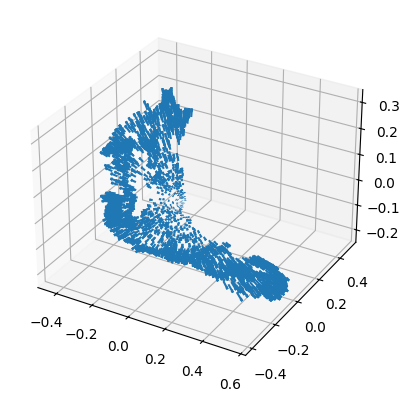

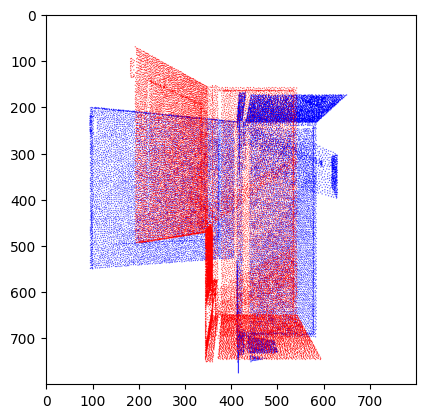

In [57]:
import visu.utils as u
import importlib
importlib.reload(u)

dir_name = {
    dataset_train: root_dir,
    dataset_test_inter: test_inter_dir,
    dataset_test_intra: test_intra_dir
}
log_name = {
    dataset_train: "train",
    dataset_test_inter: "inter",
    dataset_test_intra: "intra"
}
u.random_show_flow(gpv_net, flownet, dataset_train, dir_name, use_gt=True)

error1:  127.65687310406764
error2:  11.971255791374276


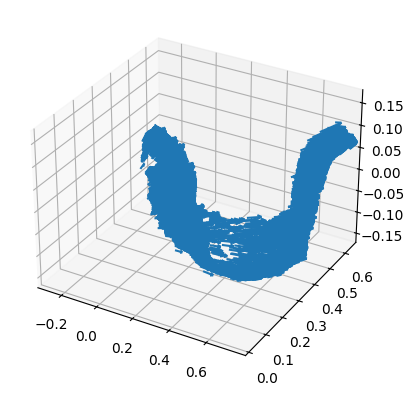

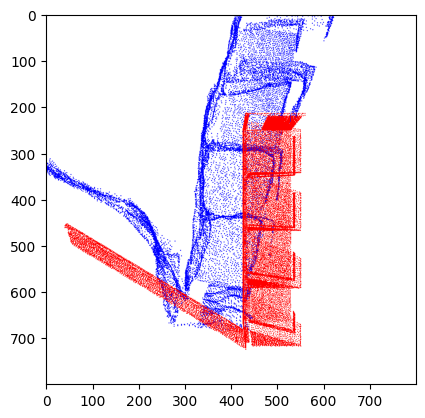

In [53]:
import visu.utils as u
import importlib
importlib.reload(u)

dir_name = {
    dataset_train: root_dir,
    dataset_test_inter: test_inter_dir,
    dataset_test_intra: test_intra_dir
}
log_name = {
    dataset_train: "train",
    dataset_test_inter: "inter",
    dataset_test_intra: "intra"
}
u.random_show_flow_pc1_to_pc2(gpv_net, flownet, dataset_train, dir_name)

In [15]:
# check pair
gpv_net.cpu()
dir_name = {
    dataset_train: root_dir,
    dataset_test_inter: test_inter_dir,
    dataset_test_intra: test_intra_dir
}
log_name = {
    dataset_train: "train",
    dataset_test_inter: "inter",
    dataset_test_intra: "intra"
}
datasets = [dataset_train, dataset_test_inter, dataset_test_intra]
random_check_pair(gpv_net, datasets, dir_name, log_name, transpose=True)

index:  2577
datasets:  /16T/zhangran/GAPartNet_re_rendered/train
Box_100676_0_6  and  Box_100676_0_7
rot1:  tensor([[[ 0.4592, -0.8972, -0.0603],
         [-0.7277, -0.3186, -0.5976],
         [ 0.5095,  0.3059, -0.7992]]])
gt1:  tensor([[[ 4.2010e-01, -9.0748e-01,  5.9605e-08],
         [-6.6982e-01, -3.1008e-01, -6.7468e-01],
         [ 6.1225e-01,  2.8343e-01, -7.3811e-01]]])
vectors1:  tensor([[-0.8972, -0.3186,  0.3059]]) tensor([[ 0.4592, -0.7277,  0.5095]])
vectors_gt1:  tensor([[-0.9075, -0.3101,  0.2834]]) tensor([[ 0.4201, -0.6698,  0.6123]])
error1:  2.6484712124065943
error_gt:  0.0
rot2:  tensor([[[ 0.4084, -0.6276, -0.0969],
         [-0.5185, -0.3508, -0.7553],
         [ 0.7512,  0.6951, -0.4687]]])
gt2:  tensor([[[ 7.7618e-01, -6.3051e-01, -2.9802e-08],
         [-2.7930e-01, -3.4383e-01, -8.9654e-01],
         [ 5.6527e-01,  6.9588e-01, -4.4297e-01]]])
vectors2:  tensor([[-0.6276, -0.3508,  0.6951]]) tensor([[ 0.4084, -0.5185,  0.7512]])
vectors_gt2:  tensor([[-0.630

In [36]:
print(torch.load("log_dir/GPV_test_new_loss/2024-06-09 13:38:03.887472/GPV_[100|100].pth")["backbone.rot_green.conv1.weight"])
print(torch.load("log_dir/GPV_test_new_loss/2024-06-09 13:38:03.887472/GPV_[80|100].pth")["backbone.rot_green.conv1.weight"])

tensor([[[ 0.0278],
         [ 0.0113],
         [ 0.0254],
         ...,
         [ 0.0626],
         [-0.0098],
         [-0.0662]],

        [[ 0.0190],
         [-0.0153],
         [-0.0285],
         ...,
         [ 0.0068],
         [ 0.0090],
         [-0.0013]],

        [[ 0.0443],
         [ 0.0399],
         [ 0.0631],
         ...,
         [-0.0441],
         [-0.0199],
         [-0.0059]],

        ...,

        [[ 0.0208],
         [ 0.0258],
         [-0.0591],
         ...,
         [ 0.0430],
         [ 0.0341],
         [-0.0148]],

        [[-0.0347],
         [ 0.0224],
         [-0.0124],
         ...,
         [ 0.0159],
         [ 0.0052],
         [ 0.0233]],

        [[ 0.0229],
         [ 0.0072],
         [-0.0786],
         ...,
         [ 0.0469],
         [ 0.0280],
         [-0.0306]]], device='cuda:0')
tensor([[[ 0.0197],
         [ 0.0041],
         [ 0.0181],
         ...,
         [ 0.0546],
         [-0.0109],
         [-0.0605]],

        [[ 0.0212